In [1]:
import datetime
import pandas as pd
import sqlite3

import warnings
warnings.filterwarnings("ignore")

# Datenquellen anbinden
conn = sqlite3.connect('northwind.db')
orders = pd.read_sql_query("select * from Orders;", conn)
order_detail = pd.read_sql_query("select * from OrderDetails;", conn)
customer = pd.read_sql_query("select * from Customers;", conn)

order_detail.head()

,OrderDetailID,OrderID,ProductID,UnitPrice,Quantity,Discount
0,1,10248,11,14.0,12,0.0
1,2,10248,42,9.8,10,0.0
2,3,10248,72,34.8,5,0.0
3,4,10249,14,18.6,9,0.0
4,5,10249,51,42.4,40,0.0


In [2]:
# Tabelen in MasterDataSet verbinden
mds = pd.merge(orders, order_detail, on='OrderID', how='left')
mds2 = pd.merge(mds, customer, on='CustomerID', how='left')
mds2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2154
Data columns (total 29 columns):
OrderID           2155 non-null int64
CustomerID        2155 non-null object
EmployeeID        2155 non-null int64
OrderDate         2155 non-null object
RequiredDate      2155 non-null object
ShippedDate       2082 non-null object
ShipVia           2155 non-null int64
Freight           2155 non-null float64
ShipName          2155 non-null object
ShipAddress       2155 non-null object
ShipCity          2155 non-null object
ShipRegion        856 non-null object
ShipPostalCode    2155 non-null object
ShipCountry       2155 non-null object
OrderDetailID     2155 non-null int64
ProductID         2155 non-null int64
UnitPrice         2155 non-null float64
Quantity          2155 non-null int64
Discount          2155 non-null float64
CompanyName       2155 non-null object
ContactName       2155 non-null object
ContactTitle      2155 non-null object
Address           2155 non-null object


In [3]:
# Extraiere die Anzahl der bestellungen pro Jahr
mds2['OrderDate'] = pd.to_datetime(mds2['OrderDate'])
mds2['Orderyear'] = mds2['OrderDate'].dt.year
print(mds2['Orderyear'].value_counts()) 

1997    1059
1998     691
1996     405
Name: Orderyear, dtype: int64


In [4]:
#Calulate total purchase
mds2['TotalPurchase'] = (mds2['Quantity'] * mds2['UnitPrice']) - (mds2['Quantity'] * mds2['UnitPrice']* mds2['Discount'])
mds2[['TotalPurchase', 'Quantity', 'UnitPrice', 'Discount']].head()

,TotalPurchase,Quantity,UnitPrice,Discount
0,168.0,12,14.0,0.0
1,98.0,10,9.8,0.0
2,174.0,5,34.8,0.0
3,167.4,9,18.6,0.0
4,1696.0,40,42.4,0.0


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

forecast = mds2[['OrderDate', 'TotalPurchase']]
forecast.index = pd.DatetimeIndex(pd.to_datetime(mds2['OrderDate']))
forecast = forecast.sort_index(ascending = False)
forecast.dtypes

OrderDate        datetime64[ns]
TotalPurchase           float64
dtype: object

In [6]:
forecast2=forecast.resample('W').sum()
forecast2.tail()

,TotalPurchase
OrderDate,
1998-04-12,21074.0450
1998-04-19,52976.8250
1998-04-26,15460.6250
1998-05-03,21720.4200
1998-05-10,12885.0605


In [7]:
# Die Datumsspalte wieder aus dem Index holen
forecast2['ds'] = pd.to_datetime(forecast2.index)

# from the prophet documentation every variables should have specific names
forecast2 = forecast2.rename(columns = {'TotalPurchase': 'y'})
forecast2.head()

,y,ds
OrderDate,,
1996-07-07,2303.400,1996-07-07
1996-07-14,10296.480,1996-07-14
1996-07-21,5306.030,1996-07-21
1996-07-28,4675.985,1996-07-28
1996-08-04,8160.000,1996-08-04


In [8]:
from fbprophet import Prophet

# default uncertainty interval 80%
model = Prophet(yearly_seasonality = True, weekly_seasonality = True, interval_width = 0.95)
model.fit(forecast2)
sales_pred = model.predict(forecast2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
sales= pd.merge(forecast2, sales_pred, how = 'inner', on = 'ds')
sales[['y', 'yhat']].astype(int).tail(10)

,y,yhat
87,17454,19067
88,20914,18926
89,19593,19676
90,33137,21244
91,31768,23605
92,21074,26116
93,52976,27204
94,15460,25486
95,21720,21492
96,12885,17855


In [18]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(sales['y'], sales['yhat']))
print("Standardabweichung: ",sales['y'].std())

3981.5452110334486
Standardabweichung:  8118.122064013535


In [19]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=sales['y'], y_pred=sales['yhat'])

35.42914256022433

In [20]:
# dataframe that extends into future 6 weeks 
future_dates = model.make_future_dataframe(freq = "w", periods = 8, include_history=True)

print("Vorhersage")
future_dates.tail()

Vorhersage


,ds
100,1998-06-07
101,1998-06-14
102,1998-06-21
103,1998-06-28
104,1998-07-05


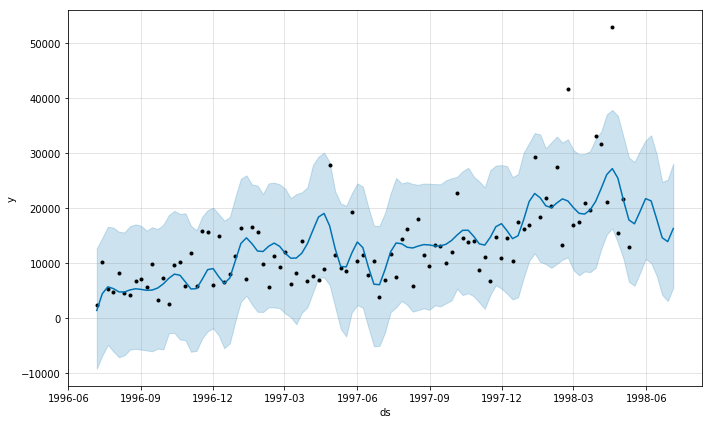

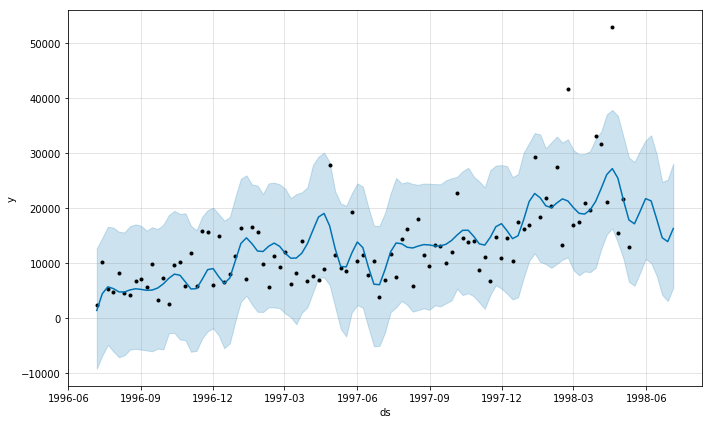

In [21]:
# predictions
sales_future = model.predict(future_dates)
model.plot(sales_future)

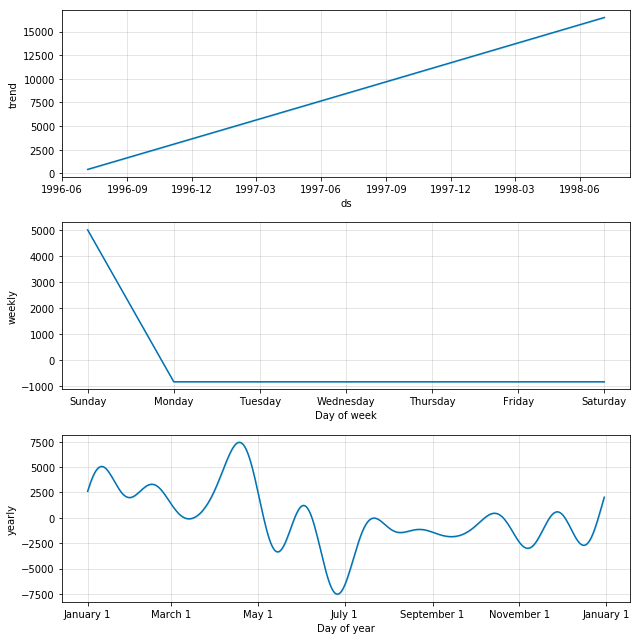

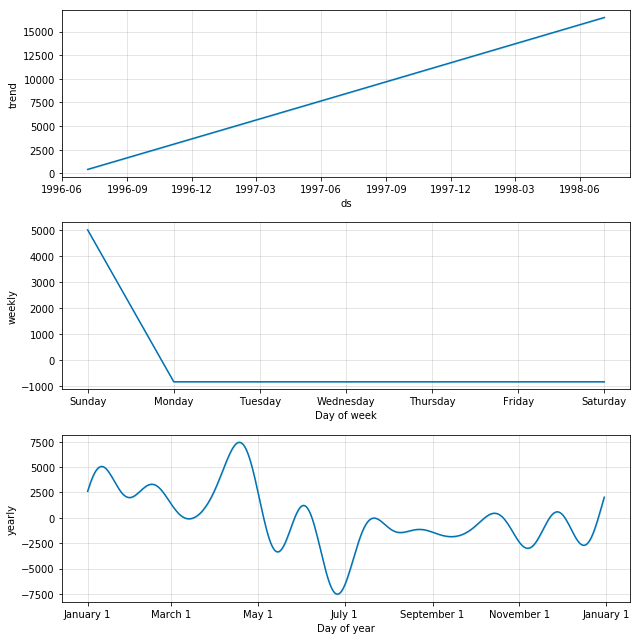

In [22]:
#One other particularly strong feature of Prophet is its ability to return the components of our forecasts.
model.plot_components(sales_future)

In [23]:
import pickle 
pickle.dump(model, open('model.pkl','wb'))

In [ ]:
# Create API of ML model using flask
from flask import Flask, request, jsonify
app = Flask(__name__)

# Load the model
model = pickle.load(open('model.pkl','rb'))

@app.route('/api',methods=['POST'])
def predict():
    # Get the data from the POST request.
    data = request.get_json(force=True)

    # Make prediction using model loaded from disk as per the data.
    prediction = model.predict(pd.to_datetime(data['ds']))
    #prediction = model.predict([[np.array(data['ds'])]])

    # Take the first value of prediction
    output = prediction[0]

    return jsonify(output)

if __name__ == '__main__':
    app.run(port=5000, debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [22/Jul/2019 11:00:58] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2019 11:01:10] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2019 11:02:02] "GET /api HTTP/1.1" 405 -
INFO:werkzeug:127.0.0.1 - - [22/Jul/2019 11:02:19] "GET /api HTTP/1.1" 405 -


In [ ]:
import requests

# URL
url = 'http://localhost:5000/api'

# Change the value of experience that you want to test
r = requests.post(url,json={'ds':'1998-07-05',})
print(r.json())